# Convolution 기법

- 공간영역기반 처리
- mask내의 원소값과 공간영역에 있는 입력 영상 화소값들을 대응되게 곱하여 출력화소값을 계산
- 이때 곱해지는 mask를 kernel이라고도 함

적용범위 : \
Blurring \
영상을 밝게 수정하면서 약간 흐리게 처리 (뽀샵) \
급격한 화소차이를 점진적으로 바뀌게 도와줌

Sharpening
약간 뚜렷하게 표시
출력화소에서 이웃간 화소차이를 크게함

In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]='1'

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 이전에 28*28으로 2차원으로 만들어줬는데
# Convolution기법은 사진 그대로를 써준다
# 28,28 뒤의 1은 흑백or컬러를 의미 -> 흑백 = 1 채널, 컬러 = 3채널
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float) / 255
X_test = X_test.reshape(X_test.shape[0], 28,28, 1).astype(float) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
model = models.Sequential()

# parameter 계산법
# parameter = weight + bias
# weight = 입력 수 x 가중치 x 출력 수


# 새로운 parameter 생성 ==> 입력수 1 x kernel(가중치)(3x3) x 출력수 32 + bias32 = 320
model.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))

# 새로운 parameter 생성 ==> 입력수 32 x kernel(가중치)(3x3) x 출력수 64 + bias 64 = 18496
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

# 2x2의 범위에서 가장 큰 값만 나타내줌... 24*24에서 12*12로 줄어들음 # 모자이크가 사용 예
# 새로운 parameter 생성x
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 전체 네트워크의 25%를 임의로 끊어버려서 뒤쪽으로 가는 순전파 양을 줄게끔함 # 효율적으로 과대적합을 막아줌
# 새로운 parameter 생성x
model.add(layers.Dropout(0.25))

# 1차원으로 데이터를 쫘악 펼침
# 새로운 parameter 생성x
# 입력수가 12(맨처음 28 -> conv2D 26 -> conv2D 24 -> flatten 12) x 12 x 64 로 바뀜 = 9216
model.add(layers.Flatten())

# 새로운 parameter 생성 ==> 입력 수 9216 x 출력 수 128 + bias 128 = 1179776
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

# 새로운 parameter 생성 ==> 입력 수 128 x 출력 수 10 + bias 10 = 1290
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

- 1 첫 번째 인자: 커널을 몇 개 적용할지 정함. 여기서는 32개의 커널을 적용

- 2 kernel_size: 커널의 크기를 정함. kernel_size=(행, 열) 형식으로 정하며, 여기서는 3×3 크기의 커널을 사용하게끔 정함

- 3 input_shape: Dense 층과 마찬가지로 맨 처음 층에는 입력되는 값을 알려 주어야함 input_shape=(행, 열, 색상 또는 흑백) 형식으로 정함. 만약 입력 이미지가 색상이면 3, 흑백이면 1을 지정함. 여기서는 28×28 크기의 흑백 이미지를 사용하도록 정함

- 4 activation: 사용할 활성화 함수를 정의

In [4]:
# 모델의 실행 옵션을 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=200, callbacks=[early_stopping])

Epoch 1/30
225/225 [==============================] - 23s 98ms/step - loss: 0.2467 - accuracy: 0.9251 - val_loss: 0.0779 - val_accuracy: 0.9775
Epoch 2/30
225/225 [==============================] - 22s 97ms/step - loss: 0.0679 - accuracy: 0.9791 - val_loss: 0.0567 - val_accuracy: 0.9835
Epoch 3/30
225/225 [==============================] - 22s 98ms/step - loss: 0.0444 - accuracy: 0.9864 - val_loss: 0.0463 - val_accuracy: 0.9865
Epoch 4/30
225/225 [==============================] - 22s 98ms/step - loss: 0.0369 - accuracy: 0.9883 - val_loss: 0.0436 - val_accuracy: 0.9867
Epoch 5/30
225/225 [==============================] - 22s 98ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 0.0446 - val_accuracy: 0.9874
Epoch 6/30
225/225 [==============================] - 24s 107ms/step - loss: 0.0246 - accuracy: 0.9918 - val_loss: 0.0446 - val_accuracy: 0.9872
Epoch 7/30
225/225 [==============================] - 22s 99ms/step - loss: 0.0209 - accuracy: 0.9930 - val_loss: 0.0421 - val_accuracy

225/225 [==============================] - 23s 101ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0518 - val_accuracy: 0.9896
Epoch 23/30
225/225 [==============================] - 22s 97ms/step - loss: 0.0074 - accuracy: 0.9973 - val_loss: 0.0561 - val_accuracy: 0.9893
Epoch 24/30
225/225 [==============================] - 23s 101ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0508 - val_accuracy: 0.9894
Epoch 25/30
225/225 [==============================] - 21s 95ms/step - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.0495 - val_accuracy: 0.9900
Epoch 26/30
225/225 [==============================] - 22s 96ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0593 - val_accuracy: 0.9895
Epoch 27/30
225/225 [==============================] - 22s 99ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0608 - val_accuracy: 0.9883
Epoch 28/30
225/225 [==============================] - 22s 98ms/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.0515 - val_accuracy: 0.

In [11]:
# 테스트의 정확도를 출력
print("Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 2s 4ms/step - loss: 0.0397 - accuracy: 0.9922
Test Accuracy: 0.9922


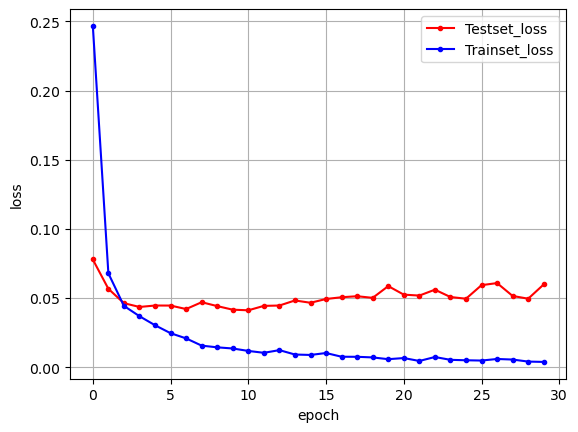

In [7]:
# 검증셋과 학습셋의 오차를 저장합니다. 
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시해 보겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()